# Numerical solution of the horizontal diffusion equation
## M. Vanclooster, 21/03/18

In this notebook, we illustrate the numerical solution of the horizontal linearised diffusion equation for water into an unsaturated soil.

The governing equation that we solve in this is: 

\begin{equation}
    \frac{\partial \theta}{\partial t}=D \frac{\partial^2 \theta}{\partial x^2}
\end{equation}

where $\theta$ is the volumetric soil water content ($m^3 m^{-3}$); $x$ ($m$), $t$ ($s$) the space and time coordinates; and $D$ the soil water diffusivity constant ($m^2 s^{-1}$). 

We start by initialising our $Python$ environment:

In [55]:
import os
import numpy as np
import scipy as sc
import math
from matplotlib import pyplot as plt
%matplotlib inline

Subsequently, we define our numerical paramaters (i.e. we define our numerical grid and grid size), our soil physical parameters, the initial conditions and the boundary conditions. In this case, we consider a constant initial condition, i.e. $\theta(x,t=0)=0.01$, and we consider as boundary conditions: $\theta(0,t\gt0)=0.4$ and $\theta(x\rightarrow \infty,t)=0.01$

In [56]:
# Numerical parameters
tsteps=10
xsteps=100
dt=0.1
dx=0.1

# Soil physical parameters 
D=1.

# Boundary conditions 
ths=0.4 
thi=0.01

#Initial conditions
th_init=thi*np.ones(shape=(1,xsteps+1))

In this case, we consider an implicit solution. In this case we define the vectors $a,b,c$ which will be used to construct a tridiagonal matrix ($tridig$). If we consider $j$ spatial steps, this tridiagonal matrix will have a size of $(j-1,j+1)$. We cut the first and last column of this tridiagonal matrix to obtain the matrix of coefficients ($A=unkmat$) with size $(j-1,j-1)$: 

In [57]:
# Implicit solution
a=(-1*D*dt/(dx**2))*np.ones(shape=(xsteps-1))
b=(2*dt*D/(dx**2)+1)*np.ones(shape=(xsteps-1))
c=(-1*D*dt/(dx**2))*np.ones(shape=(xsteps-1))

tridig=np.zeros(shape=(xsteps-1,xsteps+1))

for i in range(xsteps-1):
    for j in range(xsteps+1):
        if i == j: 
            tridig[i,j]=a[i]
            
for i in range(xsteps-1):
    for j in range(xsteps+1):
        if i == j: 
            tridig[i,j+1]=b[i]        

for i in range(xsteps-1):
    for j in range(xsteps+1):
        if i == j: 
            tridig[i,j+2]=c[i]

unk_mat=tridig[:,1:xsteps]

We include the top and bottom boundary condition in the tridiagonal matrix. We also initialise  matrices which will contain our water contents:
- th_old, a $(i,j+1)$ matrix containing the water contents before solving the equation; this matrix includes the water contents at the boundaries of the flow domain;    
- th_calc, a $(i,j+1)$ matrix containing the updated water contents obtained after solving the equation, including the boundary conditions; 
- th_new, a $(i,j-1)$ matrix containing the updated water contents; excluding the boundary conditions; 


In [58]:
top_boco=tridig[0,0]*ths
low_boco=tridig[xsteps-2,xsteps]*thi

th_old=np.zeros(shape=(tsteps,xsteps+1))
th_calc=np.zeros(shape=(tsteps,xsteps+1))
th_new=np.zeros(shape=(1,xsteps-1))

We initialise the solution for $t=0$

In [59]:
th_old[0,:]=th_init
th_calc[0,:]=th_init
th_new=th_init[0,1:xsteps]

Here we solve the flow equation. In matrix form we have: 

\begin{equation}
    A \Theta^{i+1}= \Theta^i
\end{equation}

with 
\begin{equation}
    \Theta= [\theta_1 \theta_2...\theta_{j-1}]
\end{equation}

and $A=unkmat$, the tridiagonal coefficient matrix. We obtain the new update water contents as follows: 
\begin{equation}
    A^{-1}A \Theta^{i+1}=\Theta^{i+1}= A^{-1}\Theta^i
\end{equation}
We therefore need to invert the coefficient matrix A and multiply it with vector of previous water content. Matrix inversion is done using the $linalg$ library available in $numpy$.

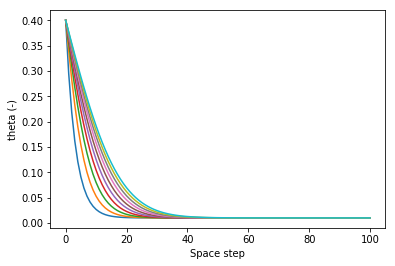

In [60]:
for i in range(tsteps):
  
    th_old[i,1:xsteps]=th_new
    th_old[i,1]=th_new[0]-top_boco
    th_old[i,xsteps-1]=th_new[xsteps-2]-low_boco
    th_new=np.dot(np.linalg.inv(unk_mat),th_old[i,1:xsteps])
    th_calc[i]=np.hstack((ths,th_new,thi))
    plt.plot(th_calc[i])
    plt.ylabel('theta (-)')
    plt.xlabel('Space step')
    

We can compare this numerical solution with the exact solution (the analytical solution). 
This analytical solution reads as follows: 

\begin{equation}
    \theta(x,t)=(\theta_s-\theta_i) \left(1-erf\left(\frac{x}{2\sqrt{D t}} \right) \right)+\theta_i
\end{equation}

    

In [61]:
x=dx*np.arange(xsteps)
t=dx*np.arange(1,tsteps)

C:\Users\vanclooster\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\Users\vanclooster\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


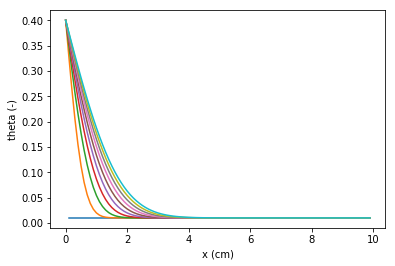

In [62]:
from scipy import special

x=dx*np.arange(xsteps)
t=dx*np.arange(tsteps)
th_analytical=np.zeros(shape=(tsteps,xsteps))


for i in range(tsteps):
    th_analytical[i]=(ths-thi)*(1-special.erf(x/(2*(D*t[i])**0.5)))+thi 
    plt.plot(x,th_analytical[i]);
    plt.xlabel('x (cm)')
    plt.ylabel('theta (-)')